word2vec: http://papers.nips.cc/paper/5021-distributed-representations

word2vec tf tutorial: https://www.tensorflow.org/versions/r0.12/tutorials/word2vec/index.html

skip-thought vectors: https://arxiv.org/abs/1506.06726
- dataset used, BookCorpus, is unfortunately allowed for affiliated academic use only: http://yknzhu.wixsite.com/mbweb

sampling losses: https://www.tensorflow.org/extras/candidate_sampling.pdf

BLESS word relation benchmark: https://sites.google.com/site/geometricalmodels/shared-evaluation

### NOTES:

strange, I can't seem to learn sensible embeddings based on the tf example. but, when I tie the input embedding to the target embedding, I do learn good embeddings. It also takes 10x more epochs. Qs: why does it work that way at all? What is the intuitive meaning of tying the embeddings? What about the bias? Why doesn't it work the normal way? Too many parameters for my data? What if I look at the target embeddings instead?

### TODO:

read up on NCE, better understand how it works in tf, why/how to implement negative sampling instead

remove infrequent words from vocab: how to deal with unknown words when projecting text?
- should all removed words map to a special 'mystery word' so they can be reconstituted in text as a placeholder?
- probably best to ignore them and leave them unaltered, same as punctuation

mapping text to embedding back to text:
- need to write own tokenizer which will store whitespace and punctuation for later reassembly
- list of word indices, list of string separators, list of capitalization/style masks
- indices -> embeddings -> transformed embeddings -> nearest neighbor indices -> words -> styled words

for word pairs, compare rank by embedding distance to rank by frequency of co-occurence to test whether synonyms which don't actually appear together still embed together

[binder](http://docs.mybinder.org/release-notes)

### IDEAS:

char-RNN for embedding: rather than lookup, embedding vectors are final state of RNN run on words with 1-hot character reps/ or character embeddings from lookup
- has it been done?
- good: fewer parameters, possibly
- good: generalization to mis/alternate spellings, compound words
- bad: conceptual and computational complexity
- ugly: RNN still doesn't condition on context, doesn't help with polysemy or phrases

In [1]:
%load_ext autoreload
%autoreload 2

In [55]:
import sys
sys.path.append('../util/')
import libvictor as lv
from util import *
sys.path.append('../../../bhtsne')
from bhtsne import run_bh_tsne as tsne

In [49]:
#python 3
import math, os, re, operator
from collections import defaultdict

import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist,cdist,squareform
import tensorflow as tf
from keras.preprocessing.text import Tokenizer, base_filter

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
%matplotlib inline
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure

from IPython.display import display, clear_output
import ipywidgets as widgets
import traitlets
from tqdm import tqdm_notebook as tqdm

In [4]:
sns.set_style('darkgrid')

In [5]:
import pickle
def picklewrite(fname, obj):
    with open(fname, 'wb') as outfile:
        pickle.dump(obj, outfile)
def pickleread(fname):
    with open(fname, 'rb') as infile:
        return pickle.load(infile)

In [6]:
s = tf.InteractiveSession()
output_notebook()

Loading BokehJS ...

In [7]:
# get list of filenames
regex = re.compile('\w*\.txt')
text_dir = '../../../books/feedbooks'
text_files = [os.path.join(text_dir, f) for f in os.listdir(text_dir) if regex.match(f)]
len(text_files)

3485

In [8]:
# make a generator which can stream text from disk and preprocess

text_filters = "—¬–…“”"+base_filter()
# print(text_filters)
# print(apply_list('‘love’:  l’amo-\nur', text_filter_fns))

def process_txt(fname, verbose=False):
    #get rid of single quotes but not contractions
    dequote = lv.make_re_filter(r"‘|’\W|\W'|'\W", ' ')
    #repair any words broken across lines that got reified into text
    debreak = lv.make_re_filter(r'(-|—|–)\W+', '')
    #not sure why Š and š are showing up in whitespace of otherwise seemingly utf-8 text
    deess = lv.make_re_filter(r'(Š|š)', ' ')
    filter_fn = lv.compose_list([dequote, debreak, deess])
    try:
        with open(fname, "r", encoding='utf8', errors='ignore') as f:
            return filter_fn(f.read())
    except UnicodeDecodeError:
        if verbose: print('{}: falling back to latin_1 encoding'.format(fname))
        with open(fname, "r", encoding='latin1') as f:
            return filter_fn(f.read())
        
stream_texts = lambda: (process_txt(fname) for fname in tqdm(text_files))

In [9]:
# tokenize using keras

refit = False

if refit:
    tok = Tokenizer(filters=text_filters)
    print('fitting Tokenizer...')
    tok.fit_on_texts(stream_texts())
    print('saving to disk...')
    picklewrite('../bin/tokenizer.pickle', tok)
else:
    print('reading from disk...')
    tok = pickleread('../bin/tokenizer.pickle')
print('done')

reading from disk...
done


In [10]:
#remove rare words
word_freq_thresh = 30
tok.word_index = {w:i for w,i in tok.word_index.items() if tok.word_counts[w]>=word_freq_thresh}

In [11]:
# save memory at the cost of having to re-process corpus
# could instead dump the preprocessed text to disk and load here

make_seqs = True
chunk_size = None

seqs = []
if make_seqs:
    for t in stream_texts():
        seqs.append(np.array(tok.texts_to_sequences([t])[0], dtype=np.int32)-1)
    if not chunk_size is None:
        seqs = [item for seq in tqdm(seqs) for item in np.array_split(seq, int(len(seq)/chunk_size))]
    picklewrite('../bin/seqs.pickle', seqs)
else:
    seqs = pickleread('../bin/seqs.pickle')   

In [12]:
word_index = {w:i-1 for w,i in tok.word_index.items()}
vocab_size = max(word_index.values())+1
word_counts = tok.word_counts
index_words = {v:k for k,v in word_index.items()}
index_counts = np.zeros(vocab_size, dtype=np.int64)
for i in range(vocab_size):
    index_counts[i]=word_counts[index_words[i]]

print('{} words in vocabulary'.format(vocab_size))

for i in range(16):
    print('{} ({}) occurs {} times'.format(index_words[i], i, index_counts[i]))

64837 words in vocabulary
the (0) occurs 9620347 times
and (1) occurs 5286218 times
of (2) occurs 4730037 times
to (3) occurs 4501963 times
a (4) occurs 3727730 times
in (5) occurs 2666583 times
i (6) occurs 2557838 times
he (7) occurs 2505410 times
that (8) occurs 2241063 times
was (9) occurs 2219270 times
it (10) occurs 1971870 times
his (11) occurs 1762377 times
you (12) occurs 1631033 times
had (13) occurs 1435405 times
with (14) occurs 1347902 times
for (15) occurs 1288832 times


In [13]:
# hyperparameters
embed_size = 256 #dimensionality of embedding
nce_k = 2048 #number of NCE samples
learning_rate = 0.001 #optimizer learning rate

In [14]:
context_size = 16 # number of context samples per input sample. if using windows, must be even
freq_exp = 0.5 # raise word frequencies to this power before computing pmf to sample from
                # e.g. 1 means unigram, 0 uniform

# make the batch generator, which involves substantial preprocessing for large datasets
batch_generator = make_batch_generator(
    seqs, context_size, index_counts, freq_exp, use_windows=True)

precomputing cdfs



In [21]:
# %%prun
batch_size = 1
n_batches = 1
for inputs, targets in tqdm(batch_generator(batch_size, n_batches)):
    if n_batches==1:
        print(inputs)
        print(targets)
    if batch_size==1:
        input_words, target_words = ([index_words[i] for i in batch] for batch in [inputs, targets[0]])
        t = Tokenizer()
        t.fit_on_texts(input_words)
        print(sorted(t.word_counts.items(), key=operator.itemgetter(1), reverse=True))
        t = Tokenizer()
        t.fit_on_texts(target_words)
        print(sorted(t.word_counts.items(), key=operator.itemgetter(1), reverse=True))
    pass

[47599]
[[  136     2   747   160    23 11048    30     3    16     7    98     3
     75    25    39   249]]
[('golenishtchev', 1)]
[('to', 2), ('said', 1), ('vronsky', 1), ('nothing', 1), ('came', 1), ('going', 1), ('morning', 1), ("what's", 1), ('of', 1), ('one', 1), ('on', 1), ('see', 1), ('him', 1), ('as', 1), ('he', 1)]



In [22]:
s.close()
tf.reset_default_graph()
s = tf.InteractiveSession()

#parameters
embeddings = tf.Variable(tf.random_uniform([vocab_size, embed_size], -1.0, 1.0))
# nce_weights = tf.Variable(tf.truncated_normal( # do these define the v' embeddings? why different from the input embeddings?
#         [vocab_size, embed_size],
#         stddev=1.0 / np.sqrt(embed_size)
#     ))
nce_biases = tf.Variable(tf.zeros([vocab_size]))

#inputs
train_inputs = tf.placeholder(tf.int64, shape=[None]) #input word as integer
train_targets = tf.placeholder(tf.int64, shape=[None, context_size]) #target words as integers

#embed inputs
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

# NCE loss
# use a distorted unigram sampler to match the positive sample generation scheme
neg_samples = tf.nn.fixed_unigram_candidate_sampler(train_targets, context_size, nce_k, 
                                                    unique = True,
                                                    range_max = vocab_size,
                                                    distortion = 1-freq_exp,
                                                    unigrams = list(index_counts))
# loss = tf.reduce_mean(tf.nn.nce_loss(
#         nce_weights, nce_biases, embed, train_targets, nce_k, vocab_size, context_size, neg_samples
#     ))
loss = tf.reduce_mean(tf.nn.nce_loss(
        embeddings, nce_biases, embed, train_targets, nce_k, vocab_size, context_size, neg_samples
    ))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

init_op = tf.initialize_all_variables()

In [23]:
def make_train_fn(handle, epoch_idxs, losses):
    def train(n_batches, batch_size=128, epoch_size=100):
        epoch_losses = []
        batch_idx = 0
        for inputs, targets in tqdm(batch_generator(batch_size, n_batches)):
            feed_dict = {train_inputs: inputs, train_targets: targets}
            _, cur_loss = s.run([optimizer, loss], feed_dict=feed_dict)
            epoch_losses.append(cur_loss)
            batch_idx+=1
            if batch_idx == epoch_size:
                losses.append(np.mean(epoch_losses))
                epoch_idxs.append(len(epoch_idxs))
                push_notebook(handle=handle)
                batch_idx = 0
                epoch_losses = []
    return train

def init_train():
    elapsed_batches = 0
    s.run(init_op)
    epoch_idxs, losses = [], []
    #set up bokeh plot
    p = figure(title='train loss', plot_height=400, plot_width=600, y_axis_type='log')
    p.scatter(x=epoch_idxs, y=losses, radius=0.5, fill_alpha=1, line_color=None)
    return make_train_fn(show(p, notebook_handle=True), epoch_idxs, losses), losses

train, losses = init_train()

In [27]:
train(120000)

In [28]:
# index_embeddings = nce_weights.eval()
index_embeddings = embeddings.eval()
picklewrite('../bin/embeddings.pickle', index_embeddings)

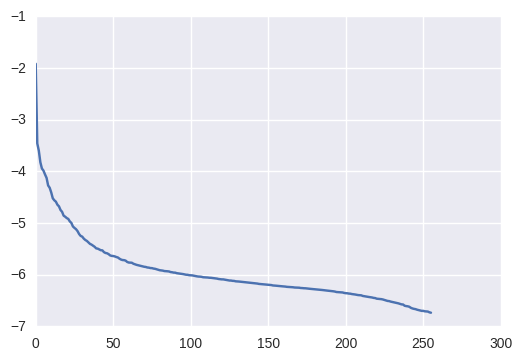

In [30]:
# when using the skip-gram model,
# this tends to look similar as at intialization, except that one single component goes to zero explained variance
# this implies that the embeddings lie on an N-1 dimensional hyperplane?
# if they were unit vectors (on a hypersphere),
# the true dimensionality would be N-1, right? but PCA shouldn't be able to find it
# unless the embeddings all clump to a small approximately planar region of the hypersphere
word_embeddings = {index_words[i]:e for i,e in enumerate(index_embeddings) if i in index_words}
estimator = PCA()
index_embeddings_pca = estimator.fit_transform(index_embeddings) 
word_embeddings_pca = {index_words[i]:e for i,e in enumerate(index_embeddings_pca) if i in index_words}
plt.plot(np.log(estimator.explained_variance_ratio_))

In [31]:
def make_embedding_plot():
    colormap = plt.cm.get_cmap("magma")
    bokehpalette = [colors.rgb2hex(m) for m in colormap(np.arange(colormap.N))]
    p = figure(title='word embedding', plot_height=384, plot_width=384, x_range=(0, 16), y_range=(0, 16))
    d = index_embeddings[1].reshape((16,16))
    im = p.image(image=[d],  x=0, y=0, dw=16, dh=16, palette=bokehpalette)
    handle = show(p, notebook_handle=True)
    def plot_index(i):
        p.title.text = str(i)
        d = index_embeddings[i].reshape((16,16))
        im.data_source.data['image'] = [d]
        push_notebook(handle=handle)
    return plot_index
update_embedding_plot = make_embedding_plot()

In [32]:
#todo: add text widget to display/set word
slider = widgets.IntSlider(min=1, max=vocab_size, continuous_update=False)    
play = widgets.Play(value=1, min=1, max=vocab_size, interval = 100)
widgets.jslink((play, 'value'), (slider, 'value'))
widgets.HBox([play,widgets.interactive(update_embedding_plot, i=slider)])

In [ ]:
@widgets.interact(w=widgets.Text(),__manual=True)
def plot_word(w='the'):
    plt.imshow(word_embeddings_pca[w].reshape((8,16)), interpolation='nearest')
    plt.grid(False)

or of whom but a few threw me an indifferent glance as well as at the far end of some solemn looking professors who were seated on chairs or walking carelessly about among some tables than i at once became disabused of the notion that i should attract the general attention while the expression of my face which at home and even in the vestibule of the university buildings had denoted only a kind of vague regret that i should have to present so important and distinguished an appearance became exchanged for an expression of the most acute nervousness and dejection however i soon picked up again when i perceived sitting at one of the desks a very badly untidily dressed gentleman who though not really old was


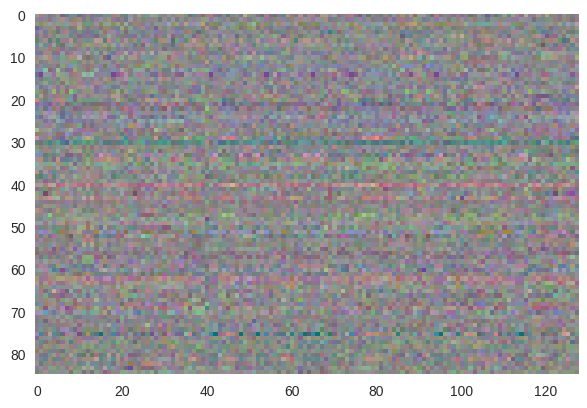

In [37]:
mean = index_embeddings.mean(0)
def norm(v):
    centered = v-mean
    return centered/np.linalg.norm(centered)
# seq = seqs[3]
# width = len(seq)
begin = 10000
width = 128
seq = seqs[3][begin:begin+width]
print(' '.join(index_words[i] for i in seq))
im = np.stack([norm(index_embeddings[i]) for i in seq],1)
# im = np.stack((im[:,:-2], im[:,1:-1], im[:,2:]),2)
im = im[:int(im.shape[0]/3)*3]
im = np.stack((im[1::3], im[2::3], im[::3]),2)
fig, ax = plt.subplots(1,1,figsize=(7,7))
ax.imshow((im-im.min())/(im.max()-im.min()), interpolation='nearest')
ax.grid(False)

or of whom but a few threw me an indifferent glance as well as at the far end of some solemn looking professors who were seated on chairs or walking carelessly about among some tables than i at once became disabused of the notion that i should attract the general attention while the expression of my face which at home and even in the vestibule of the university buildings had denoted only a kind of vague regret that i should have to present so important and distinguished an appearance became exchanged for an expression of the most acute nervousness and dejection however i soon picked up again when i perceived sitting at one of the desks a very badly untidily dressed gentleman who though not really old was


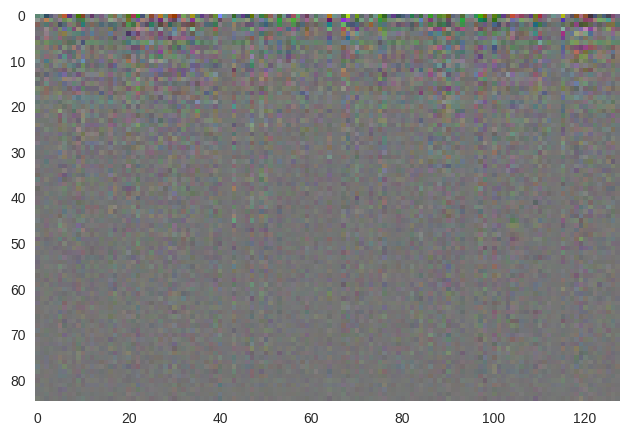

In [36]:
# looking at principal components, it's clear that common words have all their energy in the first few,
# while uncommon words are spread out over the smaller eigenvalues
# horizontal structure is also visible where sequences of words are closely related

# seq = seqs[3]
# width = len(seq)
begin = 10000
width = 128
seq = seqs[3][begin:begin+width]
print(' '.join(index_words[i] for i in seq))
im = np.stack([index_embeddings_pca[i] for i in seq],1)
# im = np.stack((im[:,:-2], im[:,1:-1], im[:,2:]),2)
im = im[:int(im.shape[0]/3)*3]
im = np.stack((im[1::3], im[2::3], im[::3]),2)
fig, ax = plt.subplots(1,1,figsize=(12,5))
ax.imshow((im-im.min())/(im.max()-im.min()), interpolation='nearest')
ax.grid(False)

In [ ]:
# for each word in vocab, compute cosine distance to other words
# store most similar and dissimilar

In [35]:
#normalize embeddings to unit vectors
index_embeddings/=np.linalg.norm(index_embeddings, axis=1, keepdims=True)

In [38]:
index_nbrs = defaultdict(dict)
for i in tqdm(range(0,1000)):
    v = index_embeddings[i]
    w = index_words[i]
    dists = (v[np.newaxis]*index_embeddings).sum(1)
    order = np.argsort(dists)
    n = 5
    assert order[-1]==i #last with cosine dist of 1 should be identity
    nearest = order[-n-1:-1][::-1]
    nearest_words = [index_words[j] for j in nearest]
    nearest_dists = dists[nearest]
#     furthest = order[:n]+1
#     furthest_words = [index_words[j] for j in furthest]
#     furthest_dists = dists[furthest-1]
    index_nbrs[w]['nearest'] = [k for k in zip(nearest_words, nearest, nearest_dists)]
#     index_nbrs[w]['furthest'] = [k for k in zip(furthest_words, furthest, furthest_dists)]
index_nbrs

defaultdict(dict,
            {'moment': {'nearest': [('hesitated', 1593, 0.62199336),
               ('instant', 697, 0.6100322),
               ('paused', 961, 0.59977078),
               ('irresolute', 16097, 0.57186341),
               ('moments', 1092, 0.57127911)]},
             'sign': {'nearest': [('signs', 1864, 0.56006694),
               ('slightest', 2192, 0.54354841),
               ('showed', 657, 0.52626145),
               ('indication', 7220, 0.52451551),
               ('relenting', 26111, 0.51761067)]},
             'forest': {'nearest': [('woods', 1556, 0.69197655),
               ('pines', 6294, 0.67655855),
               ('trees', 578, 0.66304702),
               ('forests', 4551, 0.66101623),
               ('thickets', 11183, 0.65572578)]},
             'questions': {'nearest': [('answers', 4058, 0.72133845),
               ('question', 379, 0.68511677),
               ('ask', 354, 0.66862506),
               ('asking', 1396, 0.66317737),
               ('answe

In [39]:
pc_extremes = []
n = 8
for c in index_embeddings_pca.T:
    idxs = np.argsort(c)
    neg, pos = idxs[:n], idxs[-n:]
    neg_words, pos_words = ([index_words[j] for j in idx_group] for idx_group in (neg,pos))
    neg_vals, pos_vals = c[neg], c[pos]
    neg_tups, pos_tups = list(zip(neg_words, neg, neg_vals)), list(zip(pos_words, pos, pos_vals))
    pc_extremes.append({'positive':pos_tups, 'negative':neg_tups})

In [40]:
# these show some clustering by subject matter but aren't particularly interpretable
# which makes sense if they are on a hypersphere, right?
pc_extremes

[{'negative': [('afflicted', 8000, -1.5104445111939417),
   ('stages', 7560, -1.4793333543265188),
   ('compact', 7388, -1.4710117364675397),
   ('imperfectly', 14521, -1.4489005469048135),
   ('pigeon', 8363, -1.4414994882223022),
   ('labouring', 11854, -1.4383404987318378),
   ('tormented', 7852, -1.4352443098937031),
   ("david's", 13424, -1.4347053974349235)],
  'positive': [('irresponsibly', 64115, 1.6276679639520146),
   ('markey', 59836, 1.627884537800049),
   ('glanders', 58843, 1.630226492678915),
   ('elam', 60066, 1.6332018495066245),
   ('heedfully', 61456, 1.634125855231304),
   ('tepees', 55397, 1.6383333631511088),
   ('quatrain', 56635, 1.6408241078240946),
   ('crucibles', 61845, 1.6408718258191652)]},
 {'negative': [('imposed', 6212, -1.4063839206057966),
   ('implies', 11822, -1.3582108501841423),
   ('conduct', 1570, -1.3511659730652399),
   ('blifil', 20304, -1.3431714048777423),
   ('sanction', 12025, -1.3335948164849929),
   ('clergy', 9859, -1.3300286429291646)

In [102]:
bless = build_BLESS('../../../bless-gems/BLESS.txt', word_embeddings)

rejected 2787 of 26554 tests with words missing from vocabulary


In [46]:
# cool, related words appear to be more similar than random words
test_BLESS(bless, word_embeddings)
print('relation: (mean, std) of cosine similarity of word concept, relatum pairs')
aggregate_BLESS_scores(bless)

relation: (mean, std) of per-concept means over relata


{'attri': (0.26660031, 0.15292738),
 'coord': (0.39216161, 0.20098977),
 'event': (0.26981878, 0.16653658),
 'hyper': (0.24129508, 0.25370297),
 'mero': (0.33521655, 0.17743462),
 'random-j': (0.13230342, 0.13467729),
 'random-n': (0.12942411, 0.15470977),
 'random-v': (0.14000595, 0.13714406)}

In [45]:
# use the BLESS data to look for attribute, coordinate, event, hypernym, and meronym directions
# in the embedding space:
# not sure how to interpret this, I may not be doing it right
print('relation: norm of mean difference b/t concept, relata')
test_BLESS(bless, word_embeddings, score_fn= lambda x,y: (x-y)/np.sqrt(1e-15+np.dot(x-y, x-y)))
scores = aggregate_BLESS_scores(bless)
{k:np.linalg.norm(v[0], axis=-1) for k,v in scores.items()}

relation: norm of mean difference b/t concept, relata


{'attri': 0.23621342,
 'coord': 0.029295687,
 'event': 0.27308619,
 'hyper': 0.27337715,
 'mero': 0.18589169,
 'random-j': 0.30830655,
 'random-n': 0.22080861,
 'random-v': 0.31157354}

In [58]:
# t-SNE on embeddings
tsne_embeddings = tsne(index_embeddings)#, verbose=True)

child exiting


In [59]:
tsne_embeddings.shape

(64837, 2)

glove
clarinet
tuna
grenade
ambulance
saw
sweater
yacht
revolver
pheasant


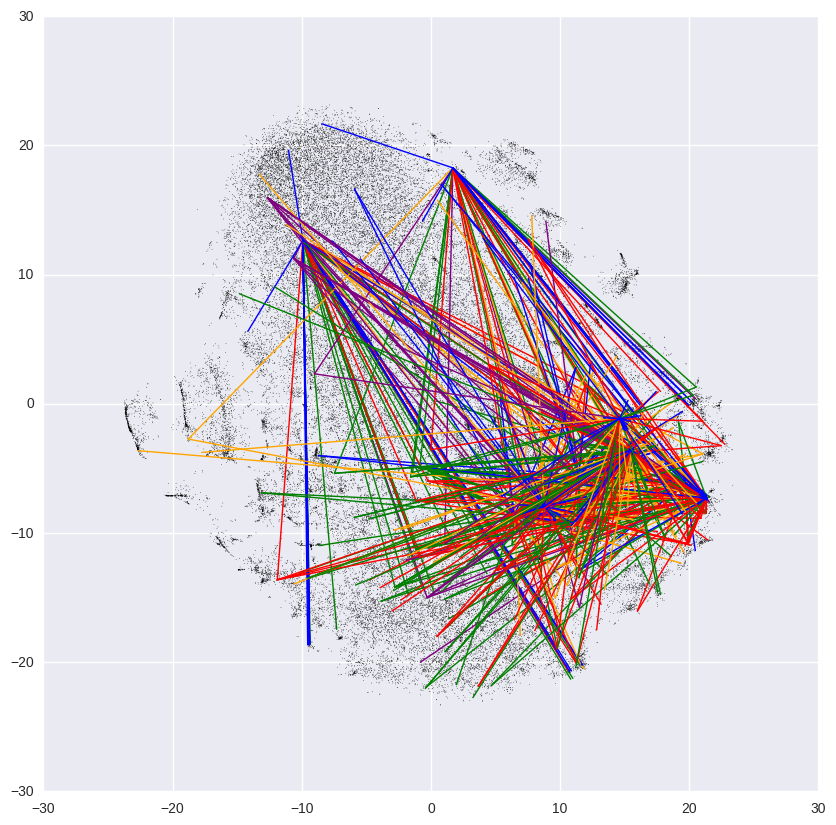

In [118]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
# index_docs = [tok.word_docs[index_words[i]] for i in range(len(tsne_embeddings))]
ax.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], marker='.', edgecolor='none', s=1, c='black')
concepts = list(bless.keys())
# concept = concepts[5]
for concept in concepts[:10]:
    print(concept)
    colors = {'attri':'red', 'coord':'blue', 'event':'green', 'hyper':'purple', 'mero':'orange'}
    for relation, relata in bless[concept].items():
        if not relation in colors: continue
        for relatum in relata:
            emb = np.array([tsne_embeddings[word_index[w]] for w in (concept, relatum)]).T
            ax.plot(*emb, color=colors[relation], lw=1)